In [1]:
######################
####  PARAMETERS. ####
######################
epochs = 100            ### Number of cycles
world_size = 200         ### Linear dimensions of the (squared) world
see_size = 20            ### DO NOT CHANGE. Dimension of the observable world.
                         ### If you change it: you have to change the DRL model input size
group_size = 6           ### DO NOT CHANGE. Linear dimensions of the (suqared) community
                         ### If you change it: you have to change the DRL model output size
filling = 0.05   ### How "full" the starting world is

IsWorldFuzzy = False    ### "Fuzzy" world means that cells have a random chance of switching
p_fuzzy = 1.0/world_size/world_size     ### Note that approx. P(1 switch) = world_size*world_size*p_fuzzy
                       ### If world_size ~ 100, p_fuzzy should be ~ 0.01 ~ to get 100 events (over 10 thousand squares)

alive = 1              ### Def. 1 alive and 0 dead 
dead = 0               ###

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import copy
from matplotlib import rc
from IPython import display
import random
%matplotlib inline
start = time.time()

from gameofsurvival_libraries import init_grid, grid_to_list, grid_to_set, list_to_grid, set_to_grid
from gameofsurvival_libraries import get_neighbours, apply_rules, fuzzy_rules, calculate_action, time_step
from gameofsurvival_libraries import alive_cells

###STARTING WORLD CONFIGURATION###


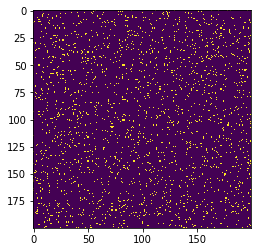

In [3]:
### Generate world and group at random
world = init_grid(world_size)
group = init_grid(group_size)

### PLOT INITIAL STATE
print("###STARTING WORLD CONFIGURATION###")
plt.imshow(world)
plt.show()

In [4]:
### IMPORTING KERAS MODULES!
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')
print(sys.path)
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import TensorBoard
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

['/Users/simonedicataldo/Desktop/gameofsurvival', '/Users/simonedicataldo/opt/anaconda3/lib/python37.zip', '/Users/simonedicataldo/opt/anaconda3/lib/python3.7', '/Users/simonedicataldo/opt/anaconda3/lib/python3.7/lib-dynload', '', '/Users/simonedicataldo/opt/anaconda3/lib/python3.7/site-packages', '/Users/simonedicataldo/opt/anaconda3/lib/python3.7/site-packages/aeosa', '/Users/simonedicataldo/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/Users/simonedicataldo/.ipython', '/usr/local/lib/python3.7/site-packages']


Using TensorFlow backend.


In [5]:
player = Sequential()
player.add(Input(shape=(see_size, see_size,1)))
## 20x20x1
player.add(Conv2D(16, (2, 2), activation='relu', padding='same'))
## 20x20x16
player.add(MaxPooling2D((2, 2), padding='same'))
## 10x10x16
player.add(Conv2D(36, (3, 3), activation='relu', padding='same'))
## 10x10x36
player.add(MaxPooling2D((2, 2), padding='same'))
## 5x5x36
player.add(Conv2D(36, (2, 2), activation='relu', padding='same'))
## 5x5x36
player.add(MaxPooling2D((6, 6), padding='same', name='encoder'))
## 1x1x36
player.add(Flatten())
player.compile(loss='mse', optimizer='adam', metrics=['mae'])

array([[0.14243077, 0.27698156, 0.07639172, 0.        , 0.0775497 ,
        0.09131198, 0.02369184, 0.08635189, 0.01314781, 0.1252281 ,
        0.        , 0.03730078, 0.05444482, 0.        , 0.04373308,
        0.04176816, 0.00922156, 0.21688107, 0.10001183, 0.13861132,
        0.14091265, 0.21675798, 0.10370015, 0.01432921, 0.13426292,
        0.        , 0.        , 0.        , 0.12625572, 0.02477156,
        0.05526185, 0.11230149, 0.22371635, 0.05296178, 0.02219605,
        0.12088138]], dtype=float32)

90
110


17

[[0.12373558 0.19803935 0.09152067 0.         0.12763788 0.05918238
  0.03718043 0.02785604 0.09338176 0.13649678 0.         0.03184504
  0.07324375 0.         0.07017433 0.09625574 0.0009564  0.20420513
  0.12697643 0.13718961 0.10902382 0.19677846 0.08722406 0.03323055
  0.12803933 0.         0.00481849 0.06300773 0.02495156 0.04522758
  0.10343421 0.08525497 0.13872464 0.0528097  0.03431402 0.11831438]]
[[0.92995205 0.99449197 0.59000865 0.48550812 0.65360599 0.62737934
  0.21504565 0.13640672 0.10642017 0.4424518  0.6369376  0.58180207
  0.13983066 0.85496015 0.65948097 0.31291731 0.50695965 0.58210203
  0.253419   0.37188803 0.21181402 0.2411644  0.62020141 0.72210628
  0.51406681 0.44802563 0.8725004  0.85669567 0.06034552 0.73992994
  0.14645838 0.17606055 0.01014074 0.92904879 0.10865166 0.87374864]]


Train on 1 samples


KeyboardInterrupt: 

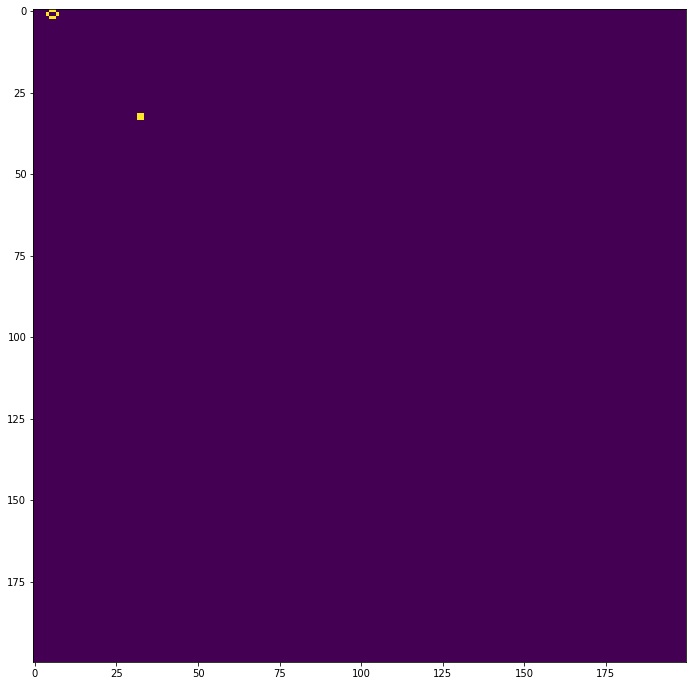

In [8]:
y = 0.95
eps = 0.5
decay_factor = 0.999
r_avg_list = []
sight_index_1 = int((world_size-see_size)/2)
sight_index_2 = int((world_size+see_size)/2-1)

%matplotlib inline
fig, ax = plt.subplots(figsize=(14, 12))
fig.canvas.draw()
img = ax.imshow(world, interpolation='none')
action = np.zeros(group_size*group_size)

for i in range(epochs):
    world = init_grid(world_size)     ### Initialize world
    alive_cells = grid_to_set(world)
    eps *= decay_factor               ### Decay probability of random action
    if i % 100 == 0:
        print("Episode {} of {}".format(i + 1, num_episodes))
    done = False
    r_sum = 0
    while not done:
        if np.random.random() < eps:
            action = np.argmax(np.random.random(group_size*group_size))
        else:
            action = np.argmax(player.predict(np.reshape(world[sight_index_1:sight_index_2,
                                                               sight_index_1:sight_index_2],
                                                         (1,see_size,see_size,1)).astype(float)))
        ### FIRST STEP: the agent performs an action on the world
        world = set_to_grid(alive_cells, world_size)
        next_world = calculate_action(action, world, world_size, group_size)
        alive_cells = grid_to_set(next_world)
        ### SECOND STEP: time evolution (including the action of the agent)
        ### RETURNS: the reward, the status of the world, and the variable "Done"
        reward, next_world, done = time_step(alive_cells, world_size, IsWorldFuzzy, p_fuzzy)
        ### UPDATE learner
        q_step = reward + y * np.max(player.predict(np.reshape(next_world[sight_index_1:sight_index_2,
                                                               sight_index_1:sight_index_2],
                                                         (1,see_size,see_size,1)).astype(float)))
        q_a_vec = player.predict(np.reshape(world[sight_index_1:sight_index_2,
                                                               sight_index_1:sight_index_2],
                                                         (1,see_size,see_size,1)).astype(float))[0]
        q_a_vec[action] = q_step
        player.fit(np.reshape(world[sight_index_1:sight_index_2,
                        sight_index_1:sight_index_2],
                    (1,see_size,see_size,1)).astype(float), 
           q_a_vec.reshape(-1,36), batch_size=1, epochs=1, verbose=0)
        r_sum += reward
        ### THIRD STEP: save "old" configuration
        world = next_world
        alive_cells = grid_to_set(world)
        ### INFORMATIVE MESSAGE
        if (i%(int(epochs/100))==0):
            print(i/epochs*100, "% of epochs done")
        ### PLOT WORLD STATUS
        if i >= (epochs-10):
            alive_cells = grid_to_set(world)
            img.set_data(world)
            display.clear_output(wait=True)
            display.display(fig)
            time.sleep(0.00000001)
    r_avg_list.append(r_sum / epochs)